# "Modulo 2"
> "Analisi della termodinamica di network random attraverso diagonalizzazione esatta dell'Hamiltoniana"

**Iniziamo** con l'implementazione dell'algoritmo che diagonalizza l'Hamiltoniana di un modello di Ising quantistico 1D con interazioni a primi vicini.

L'implementazione consiste in alcuni step:

1. Si costruisce la base con cui rappresenterò l'Hamiltoniana

2. Si costruisce l'Hamiltoniana

3. Si trova l'autovalore minore e l'autovettore corrispondente (Ground State)

4. Si calcola la magnetizzazione associata al Ground State

5. Si calcola la suscettività magnetica e il calore specifico

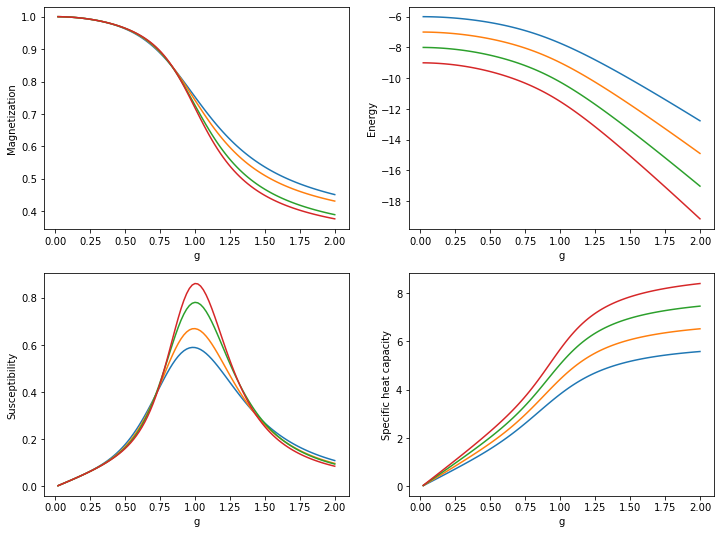

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ss
from scipy.sparse import lil_matrix


hh=0
volte=100
volte+=1

lins=np.linspace(0,2,volte)
linell=np.arange(6,10)
nell=linell.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
xi=np.zeros((volte+1,nell))
ci=np.zeros((volte+1,nell))


ell1=0
for ell in linell:
    ggg=0
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        # Sigma_z Sigma_z [coupling]

        for iHam in range(ell-1):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==iSpin[ii,iHam+1]:
                    HamOut[ii,ii]=HamOut[ii,ii]-1
                else: HamOut[ii,ii]=HamOut[ii,ii]+1

        # This implements periodic boundary conditions
        if PBC:
            for ii in range(NumTot):
                if iSpin[ii,ell-1]==iSpin[ii,0]:
                    HamOut[ii,ii]=HamOut[ii,ii]-1
                else: HamOut[ii,ii]=HamOut[ii,ii]+1

        # Sigma_z  [longitudinal field]

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    HamOut[ii,ii]=HamOut[ii,ii]-hh
                else: HamOut[ii,ii]=HamOut[ii,ii]+hh

        # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ss.eigsh(HamOut,1,which='SA')[0]
        Psi=ss.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagX=np.zeros(ell)
        MagZ=np.zeros(ell)
        MagnetZ=0

        for iSite in range(ell):
            Mx_sum=0
            for ii in range(NumTot):
                if iSpin[ii,iSite] == 1:
                    MagZ[iSite] = MagZ[iSite] + abs(Psi[ii])**2
                    Exc = ii -2**(iSite)
                else:
                    MagZ[iSite] = MagZ[iSite] - abs(Psi[ii])**2
                    Exc = ii +2**(iSite)
                Mx_sum = Mx_sum + np.conjugate(Psi[ii]) * Psi[Exc]
            if abs(np.imag(Mx_sum))>10**(-10):
                print("Non real magnetization")
            MagX[iSite] = np.real(Mx_sum) 

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        xi[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        ci[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        
        ggg+=1
    ell1+=1


magniz1=magniz
Egs1=Egs
xi1=xi
ci1=ci
    
plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(lins[1:],magniz[1:])
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.plot(lins[1:],Egs[1:volte])
#plt.ylim(-1,1)
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
plt.plot(lins[1:],xi[1:volte])
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.plot(lins[1:],ci[1:volte])
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    


plt.show()

Come possiamo notare la suscettività magnetica presenta un picco in corrispondenza di $g=1$ che all'aumentare della taglia del sistema diventa sempre più accentuato, ad indicare che nel limite termodinamico si osserva un punto critico ed il sistema presenta una transizione da una fase ferromagnetica ad una paramagnetica all'aumentare di $g$.

Per studiare meglio questo effetto procediamo con uno studio Finite Size Scaling.



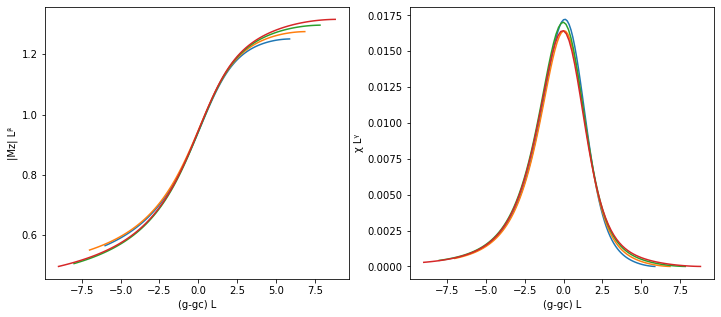

In [2]:
Fmagniz=np.zeros((volte,nell))
Fxi=np.zeros((volte+1,nell))
Flins=np.zeros((volte,nell))

ell1=0
for ell in linell:

    Fmagniz[:,ell1]=magniz[:,ell1]*(ell)**(1/8)
    Fxi[:,ell1]=(xi[:,ell1]/(ell))**(7/4)
    Flins[:,ell1]=(lins-1)*(ell)
    
    ell1+=1


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(Flins[1:],Fmagniz[1:])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('|Mz| Lᵝ')


plt.subplot(122)
plt.plot(Flins[1:],Fxi[1:volte])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('χ Lᵞ')


plt.show()

Il Finite Size Scaling è stato operato inserendo come esponenti critici quelli conosciuti tramite la risoluzione analitica del problema ovvero:
$$\beta=1/8, \quad \gamma=7/4, \quad   \nu=1, \quad    Y_g=1$$

avendo considerato il caso con campo esterno longitudinale $h=0$


## Implementazione della matrice di adiacenza

Al fine di poter calcolare le osservabili termodinamiche di un sistema con connessioni random è necessario implementare nell'algoritmo un modo per rappresentare le connessioni attraverso una matrice di adiacenza.

Per farlo andremo ad aggiungere uno step alla costruzione dell'Hamiltoniana in cui, data una matrice di adiacenza con alcuni elementi diversi da zero, andremo a controllare per ogni collegamento, se gli spin corrispondenti agli indici dell'elemento diverso da zero sono concordi o discordi ed andremo ad aggiungere o togliere energia alla configurazione considerata. 

La matrice di adiacenza essendo sparsa non verra considerata tutta, ma solo gli elementi diversi da zero, per velocizzare la compilazione.

Per verificare il giusto comportamento del nuovo codice, questo è stato testato usando come matrice di adiacenza proprio quella relativa ad un reticolo 1D con connessioni a primi vicini, per poi essere confrontato con i risultati precedenti che devono risultare uguali.

Introduciamo quindi una funzione che genera le matrici di adiacenza relative a reticoli d-dimensionali aventi L elementi per lato:

In [3]:
def AdD(d,L):
    # This function returns the sparse adjacency matrix of a d-dimensonal  
        # integer lattice with side L and the total number of elements L**d
    # Only for Periodic Boundary Conditions
    
    import scipy.sparse as ss
    N=L**d
    A=ss.dok_matrix((N,N))
    for i in range(N):
        for j in range(d):
            A[i,(i+L**j)%N] = 1
            A[i,(i-L**j)%N] = 1
    return A.copy().tocoo(), N

E testiamo quindi il funzionamento del codice aggiornato per implementare le matrici di adiacenza:

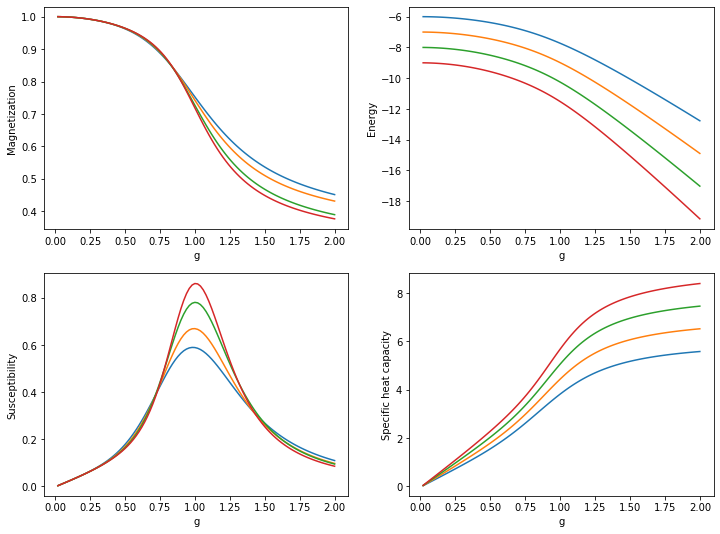

In [87]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.sparse as ss
from scipy.sparse import lil_matrix

hh=0
volte=100
volte+=1

lins=np.linspace(0,2,volte)
linell=np.arange(6,10)
nell=linell.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
xi=np.zeros((volte+1,nell))
ci=np.zeros((volte+1,nell))

jay=-1/2


ell1=0
for ell in linell:
    ggg=0
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    net=AdD(1,ell)[0]
    coll=ss.find(net)
    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        for iHam in range(len(coll[2])):
            for ii in range(NumTot):
                if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                    HamOut[ii,ii]=HamOut[ii,ii] + jay
                else: HamOut[ii,ii]=HamOut[ii,ii] - jay

        # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagX=np.zeros(ell)
        MagZ=np.zeros(ell)
        MagnetZ=0

        for iSite in range(ell):
            Mx_sum=0
            for ii in range(NumTot):
                if iSpin[ii,iSite] == 1:
                    MagZ[iSite] = MagZ[iSite] + abs(Psi[ii])**2
                    Exc = ii -2**(iSite)
                else:
                    MagZ[iSite] = MagZ[iSite] - abs(Psi[ii])**2
                    Exc = ii +2**(iSite)
                Mx_sum = Mx_sum + np.conjugate(Psi[ii]) * Psi[Exc]
            if abs(np.imag(Mx_sum))>10**(-10):
                print("Non real magnetization")
            MagX[iSite] = np.real(Mx_sum) 

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        xi[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        ci[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        
        
        ggg+=1
    ell1+=1


magniz2=magniz
Egs2=Egs
xi2=xi
ci2=ci

plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(lins[1:],magniz2[1:])
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.plot(lins[1:],Egs2[1:volte])
#plt.ylim(-1,1)
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
plt.plot(lins[1:],xi2[1:volte])
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.plot(lins[1:],ci2[1:volte])
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

I grafici rislutano identici a quelli precedenti ed insieme al Finite Size Scaling sotto ci conferma il corretto funzionamento del codice.

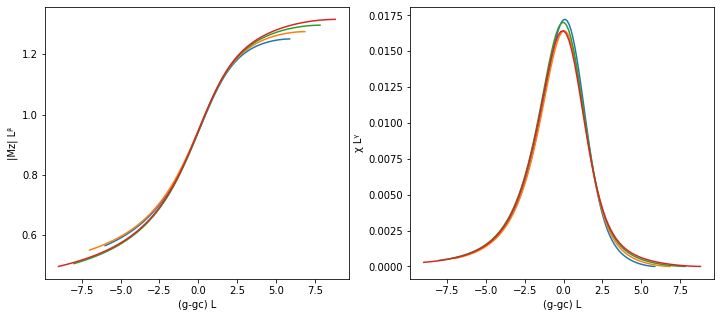

In [27]:
#collapse
Fmagniz=np.zeros((volte,nell))
Fxi=np.zeros((volte+1,nell))
Flins=np.zeros((volte,nell))

ell1=0
for ell in linell:

    Fmagniz[:,ell1]=magniz2[:,ell1]*(ell)**(1/8)
    Fxi[:,ell1]=(xi2[:,ell1]/(ell))**(7/4)
    Flins[:,ell1]=(lins-1)*(ell)
    
    ell1+=1


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(Flins[1:],Fmagniz[1:])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('|Mz| Lᵝ')


plt.subplot(122)
plt.plot(Flins[1:],Fxi[1:volte])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('χ Lᵞ')


plt.show()

Ora sfruttiamo questo stesso procedimento per studiare il modello di Ising quantistico 2D, usando la matrice di adiacenza opportuna, e confrontarlo con i risultati Monte-Carlo della relazione precedente per un Ising classico 3D, verificando il Quantum to Classical Mapping.

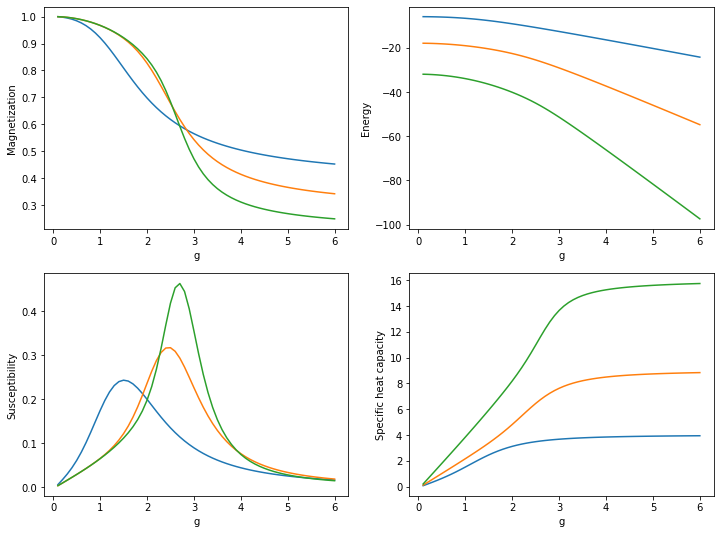

In [37]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.sparse as ss
from scipy.sparse import lil_matrix

hh=0
volte=60
volte+=1

lins=np.linspace(0,6,volte)
linell=np.arange(2,5)
nell=linell.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
xi=np.zeros((volte+1,nell))
ci=np.zeros((volte+1,nell))

jay=-1/2


ell1=0
for ell in linell:
    ggg=0
    
    net=AdD(2,ell)[0]
    coll=ss.find(net)
    
    ell=ell*ell
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    

    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        for iHam in range(len(coll[2])):
            for ii in range(NumTot):
                if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                    HamOut[ii,ii]=HamOut[ii,ii] + jay
                else: HamOut[ii,ii]=HamOut[ii,ii] - jay

        # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagX=np.zeros(ell)
        MagZ=np.zeros(ell)
        MagnetZ=0

        for iSite in range(ell):
            Mx_sum=0
            for ii in range(NumTot):
                if iSpin[ii,iSite] == 1:
                    MagZ[iSite] = MagZ[iSite] + abs(Psi[ii])**2
                    Exc = ii -2**(iSite)
                else:
                    MagZ[iSite] = MagZ[iSite] - abs(Psi[ii])**2
                    Exc = ii +2**(iSite)
                Mx_sum = Mx_sum + np.conjugate(Psi[ii]) * Psi[Exc]
            if abs(np.imag(Mx_sum))>10**(-10):
                print("Non real magnetization")
            MagX[iSite] = np.real(Mx_sum) 

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        xi[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        ci[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        
        
        ggg+=1
    ell1+=1


magniz3=magniz
Egs3=Egs
xi3=xi
ci3=ci

plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(lins[1:],magniz3[1:])
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.plot(lins[1:],Egs3[1:volte])
#plt.ylim(-1,1)
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
plt.plot(lins[1:],xi3[1:volte])
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.plot(lins[1:],ci3[1:volte])
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

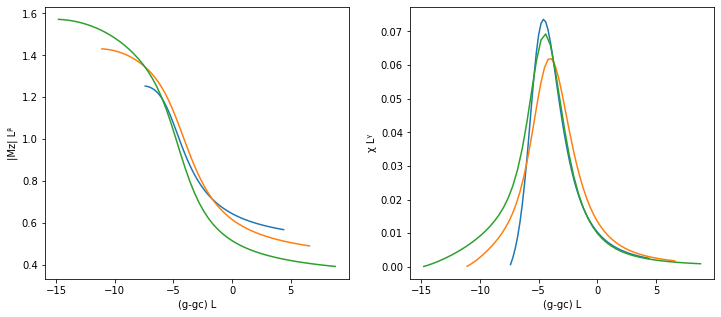

In [85]:
#collapse
Fmagniz=np.zeros((volte,nell))
Fxi=np.zeros((volte+1,nell))
Flins=np.zeros((volte,nell))

ell1=0
for ell in linell:

    Fmagniz[:,ell1]=magniz3[:,ell1]*(ell)**(0.326419)
    Fxi[:,ell1]=(xi3[:,ell1]/(ell))**(1.237075)
    Flins[:,ell1]=(lins-3.8)*(ell)
    
    ell1+=1


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(Flins[1:],Fmagniz[1:])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('|Mz| Lᵝ')


plt.subplot(122)
plt.plot(Flins[1:],Fxi[1:volte])
plt.xlabel('(g-g𝖼) L')
plt.ylabel('χ Lᵞ')


plt.show()

Vabbè, non viene bene ma il numero di siti per lato è bassissimo.

## Studio di sistemi con connessioni random

Passiamo dunque ora allo studio di un sistema le cui connessioni tra elementi sono rappresentate da una matrice di adiacenza random, ovvero in cui gli elementi della matrice diversi da zero sono disposti in maniera casuale all'interno della matrice stessa. La matrice di adiacenza è data da una funzione delle libreria SciPy che prende in input le dimensioni della matrice e la densità di elementi diversi da zero che si vuole ottenere. Per esempio per un sistema di 10 elementi come quello seguente, prendendo in input i valori (10, 10, 0.2) la funzione rand() restituisce una matrice 10x10 con 20 elementi diversi da zero scelti a caso. 

Poichè per gli stessi valori di input la funzione restituisce realizzazioni diverse di sistemi con le stesse caratteristiche, per avere un comportamento generale verranno calcolate varie realizzazioni di sistemi con gli stessi parametri e i valori di output verranno mediate fra tutte le realizzazioni. Il grafico della media è evidenziato in blu.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:127: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


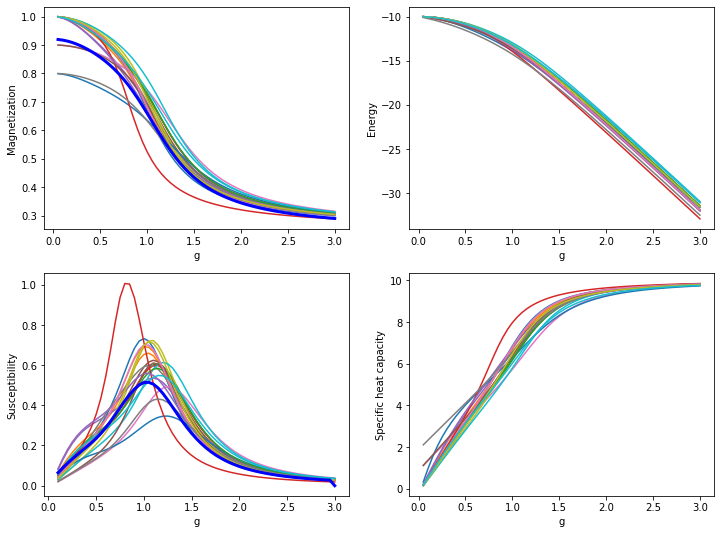

In [12]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.sparse as ss
from scipy.sparse import lil_matrix

hh=0
volte=60
volte+=1

lins=np.linspace(0,3,volte)
linum=np.arange(20)
nell=linum.size

magniz=np.zeros((volte,nell))
Egs=np.zeros((volte+1,nell))
xi=np.zeros((volte+1,nell))
ci=np.zeros((volte+1,nell))

jay=-1/2

ell=10
ell1=0
for numer in linum:
    ggg=0
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    net=ss.rand(ell,ell,2/ell)       # Matrice di Adiacenza Random
    coll=ss.find(net)
    
    for gg in lins:

        PBC=True


        # Costruisco la base

        iSpin=np.zeros((NumTot,ell))
        for ii in range(NumTot):
            itemp=ii
            for jj in range(ell):
                iSpin[ii,jj]=np.floor(itemp%2)
                itemp=itemp/2


        # Costruisco l'Hamiltoniana

        HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

        for iHam in range(len(coll[2])):
            for ii in range(NumTot):
                if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                    HamOut[ii,ii]=HamOut[ii,ii] + jay
                else: HamOut[ii,ii]=HamOut[ii,ii] - jay

        # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

        for iHam in range(ell):
            for ii in range(NumTot):
                if iSpin[ii,iHam]==1:
                    Exc = ii - 2**(iHam)
                else: Exc = ii + 2**(iHam)
                HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

        # Trovo l'autostato del GS

        Egs[ggg,ell1]=ssl.eigsh(HamOut,1,which='SA')[0]
        Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
        Psii[ggg]=Psi.copy()

        # Calcolo la magnetizzazione

        MagX=np.zeros(ell)
        MagZ=np.zeros(ell)
        MagnetZ=0

        for iSite in range(ell):
            Mx_sum=0
            for ii in range(NumTot):
                if iSpin[ii,iSite] == 1:
                    MagZ[iSite] = MagZ[iSite] + abs(Psi[ii])**2
                    Exc = ii -2**(iSite)
                else:
                    MagZ[iSite] = MagZ[iSite] - abs(Psi[ii])**2
                    Exc = ii +2**(iSite)
                Mx_sum = Mx_sum + np.conjugate(Psi[ii]) * Psi[Exc]
            if abs(np.imag(Mx_sum))>10**(-10):
                print("Non real magnetization")
            MagX[iSite] = np.real(Mx_sum) 

        for ii in range(NumTot):
            Mag_ii = 0
            for iSite in range(ell):
                if iSpin[ii,iSite] == 1:
                    Mag_ii = Mag_ii + 1
                else:
                    Mag_ii = Mag_ii - 1
            MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

        magniz[ggg,ell1]=MagnetZ/ell
        xi[ggg,ell1]=-(magniz[ggg-1,ell1]-magniz[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        ci[ggg,ell1]=-(Egs[ggg-1,ell1]-Egs[ggg,ell1])/(lins[ggg-1]-lins[ggg])
        
        #Ezero[ell//2-2]=Egs[20]
        
        ggg+=1
    ell1+=1


magniz5=magniz
Egs5=Egs
xi5=xi
ci5=ci

plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(lins[1:],magniz5[1:])
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(221)
plt.plot(lins[1:],np.sum(magniz5[1:,1:],axis=1)/magniz5[1:].shape[1],color='b', linewidth=3.0)
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.plot(lins[1:],Egs5[1:volte])
#plt.ylim(-1,1)
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
plt.plot(lins[2:],xi5[2:volte])
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(223)
plt.plot(lins[2:],np.sum(xi5[3:,2:volte],axis=1)/xi5[2:volte].shape[1],color='b', linewidth=3.0)
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.plot(lins[1:],ci5[1:volte])
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

Per tutte le realizzazioni si osserva un punto di transizione di fase per valori di $g$ intorno ad 1 con una media poco superiore ad 1. 

Il sistema precedente aveva come densità di elemeti diversi da zero $d=0.2$. È possibile che il valore del punto di transizione dipenda da questo valore? Per rispondere a questa domanda possiamo procedere con uno studio delle medie di varie realizzazioni con densità variabili da 0.1 a 1, poichè il caso $d=0$ è banale e corrisponde ad un sistema senza interazioni e quindi senza magnetizzazione.

In [ ]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.sparse as ss
from scipy.sparse import lil_matrix

hh=0
volte=100
volte+=1
nrip=5

lins=np.linspace(0,10,volte)
linum=np.arange(1,10)
nell=linum.size

magnizR=np.zeros((volte,nell,nrip))
EgsR=np.zeros((volte+1,nell,nrip))
xiR=np.zeros((volte+1,nell,nrip))
ciR=np.zeros((volte+1,nell,nrip))

jay=-1/2

ell=9
ell1=0
for numer in linum:
    
    NumTot=2**ell
    ev=np.zeros((volte,NumTot))
    Psii=np.zeros((volte,NumTot))
    
    net=ss.rand(ell,ell,numer/ell)   # Matrice di Adiacenza Random
    coll=ss.find(net)
    
    for rip in range(nrip):
        ggg=0
        for gg in lins:

            # Costruisco la base

            iSpin=np.zeros((NumTot,ell))
            for ii in range(NumTot):
                itemp=ii
                for jj in range(ell):
                    iSpin[ii,jj]=np.floor(itemp%2)
                    itemp=itemp/2


            # Costruisco l'Hamiltoniana

            HamOut=lil_matrix(np.zeros((NumTot,NumTot)))

            for iHam in range(len(coll[2])):
                for ii in range(NumTot):
                    if iSpin[ii,coll[0][iHam]]==iSpin[ii,coll[1][iHam]]:
                        HamOut[ii,ii]=HamOut[ii,ii] + jay
                    else: HamOut[ii,ii]=HamOut[ii,ii] - jay

            # Sigma_x  [transverse field]   contorta ma torna: in pratica cambia lo spin al sito j

            for iHam in range(ell):
                for ii in range(NumTot):
                    if iSpin[ii,iHam]==1:
                        Exc = ii - 2**(iHam)
                    else: Exc = ii + 2**(iHam)
                    HamOut[int(Exc),ii] = HamOut[int(Exc),ii] + gg

            # Trovo l'autostato del GS

            EgsR[ggg,ell1,rip]=ssl.eigsh(HamOut,1,which='SA')[0]
            Psi=ssl.eigsh(HamOut,1,which='SA')[1].T[0]
            Psii[ggg]=Psi.copy()

            # Calcolo la magnetizzazione

            MagX=np.zeros(ell)
            MagZ=np.zeros(ell)
            MagnetZ=0

            for iSite in range(ell):
                Mx_sum=0
                for ii in range(NumTot):
                    if iSpin[ii,iSite] == 1:
                        MagZ[iSite] = MagZ[iSite] + abs(Psi[ii])**2
                        Exc = ii -2**(iSite)
                    else:
                        MagZ[iSite] = MagZ[iSite] - abs(Psi[ii])**2
                        Exc = ii +2**(iSite)
                    Mx_sum = Mx_sum + np.conjugate(Psi[ii]) * Psi[Exc]
                if abs(np.imag(Mx_sum))>10**(-10):
                    print("Non real magnetization")
                MagX[iSite] = np.real(Mx_sum) 

            for ii in range(NumTot):
                Mag_ii = 0
                for iSite in range(ell):
                    if iSpin[ii,iSite] == 1:
                        Mag_ii = Mag_ii + 1
                    else:
                        Mag_ii = Mag_ii - 1
                MagnetZ = MagnetZ + abs(Mag_ii)*(abs(Psi[ii])**2)

            magnizR[ggg,ell1,rip]=MagnetZ/ell
            xiR[ggg,ell1,rip]=-(magnizR[ggg-1,ell1,rip]-magnizR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])
            ciR[ggg,ell1,rip]=-(EgsR[ggg-1,ell1,rip]-EgsR[ggg,ell1,rip])/(lins[ggg-1]-lins[ggg])

            ggg+=1
    
    magniz6=np.mean(magnizR,axis=2)
    Egs6=np.mean(EgsR,axis=2)
    xi6=np.mean(xiR,axis=2)
    ci6=np.mean(ciR,axis=2)
    
    ell1+=1


plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(lins[1:],magniz6[1:])
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.plot(lins[1:],Egs6[1:volte])
#plt.ylim(-1,1)
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
plt.plot(lins[2:],xi6[2:volte])
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.plot(lins[1:],ci6[1:volte])
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

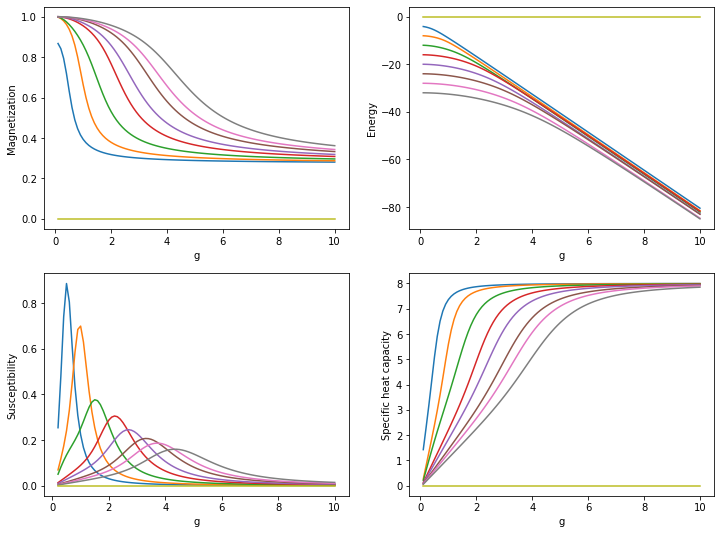

In [22]:
plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(lins[1:],magniz6[1:])
plt.xlabel('g')
plt.ylabel('Magnetization')

plt.subplot(222)
plt.plot(lins[1:],Egs6[1:volte])
#plt.ylim(-1,1)
plt.xlabel('g')
plt.ylabel('Energy')

plt.subplot(223)
plt.plot(lins[2:],xi6[2:volte])
plt.xlabel('g')
plt.ylabel('Susceptibility')

plt.subplot(224)
plt.plot(lins[1:],ci6[1:volte])
plt.xlabel('g')
plt.ylabel('Specific heat capacity')
    
plt.show()

Studiamo adesso il comportamento di un sistema di Ising quantistico 1D a cui aggiungiamo interazioni a lungo raggio random come quelle studiate sopra. Osserveremo il comportamento di questo sistema considerando le interazioni a lungo raggio prima ferromagnetiche poi antiferromagnetiche.